# Ingenería de datos

In [1]:
import pandas as pd
import numpy as np
import warnings
#import missingno as msno
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import kstest

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

Acorde se vayan incluyendo diversos datos a nuestro dataset base, pueden ocurrir dos cosas: 

1. Mejorar el perfomance al obtener nueva data que pueda discriminar correctamente el vector objetivo.
2. Empeorar el perfomance al aumentar la complejidad de la data (maldición de dimensionalidad) o aumentar el ruido al tratar de predecir el vector objetivo colocando atributos no pertinentes.

Por esta razón como forma de apoyo posterior ala ingenería de atributos y tener un seguimiento de la integridad de la data, se hará un modelo en cada sección en que se agregue un nuevo dataset, los cuales estáran mencionados como "checkpoints".

# Primer checkpoint (base)

Importación de los datasets "base": egreso y los dos de matrícula universitaria. Sirviendo la de egreso como la tabla que permite la unión entre la educación superior y la educación media.

In [28]:
egreso = pd.read_csv(r"C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1/20200228_Notas_y_Egresados_Enseanza_Media_2017_WEB.csv",sep=",", decimal=".")
matricula_universidad_1 = pd.read_csv(r"C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1/Matricula_Ed_Superior_2018.csv",sep=";", decimal=".")
matricula_universidad_2 = pd.read_csv(r"C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1/Matricula_Ed_Superior_2019.csv",sep=";", decimal=".")

In [32]:
egreso.shape

(250934, 9)

In [30]:
egreso_2017 = egreso[(egreso['marca_egreso'] == 1) & (egreso['cod_grado'] == 4)]

In [31]:
egreso_2017 = egreso_2017.drop_duplicates(subset=["mrun"],keep="first")
egreso = egreso_2017
len(egreso_2017)

250934

Poseemos 9 millones de registros de egresados, quienes van a determinar la cantidad de filas a utilizar en el dataset, pues este es el conjunto de los individuos a analizar.

Para trabajar con los dos datasets de universidad se proceden a simplemente concatenarlos, para evitar duplicados se procede con un drop_duplicates manteniendo los primeros en ser registrado (2018). Luego dependiendo de la pc a utilizar se procede o no a utilizar una submuestra de cien mil registros, para efectos del ingeniero de datos solo puede utilizar los cien mil datos, pero para efectos de varios de los colegas es posible contar con 64 gb de ram, por lo que se tiene que comentar o no el subsampling de egreso dependiendo de la capacidad del ambiente.

In [33]:
matricula = pd.concat([matricula_universidad_1, matricula_universidad_2],axis=0)
matricula = matricula.drop_duplicates(subset=["MRUN"],keep="first")
# egreso = egreso.loc[np.random.choice(egreso.index, 100000, replace=False)]

Simplemente se le coloca exactamente el mismo nombre (pandas es case sensitive) a la key necesaria para hacer el merge. Posteriormente se procede a hacer el primer merge. Tambíen se hace un drop_duplicates para los datos de media para asegurarnos la unicidad.

In [42]:
egreso["MRUN"] = egreso["mrun"]
egreso.drop(["mrun"],axis=1)
egreso = egreso.drop_duplicates(subset=["MRUN"],keep="first")
matricula_general = pd.merge(egreso,matricula, on=["MRUN"],how="left")

Ahora con los datos de egreso es posible determinar nuestro vector objetivo, este vector es determinado por la existencia (ingresó a la educación superior) o no (no logró ingresar) del individuo dentro de la matrícula de educación superior, por lo cual se ejeucta un notnull y isnull repectivamente. Tener presente que 1 es ingresó y 0 es no ingresó. 

# Se genera vector objetivo
- El vector objetivo corresponde a una variable binaria 1: ingresa a Ed. superior, 0: No ingresa a la Ed. Superior.
- Para generar el vector objetivo se obtienen todos los estudiantes que egresan de Educación media en el año 2017. Posterior a esto se busca cuales estudiantes se encuentran registrados en las matriculas de educación superior de los años 2018 y/o 2019.
- adicionalmente y solo con fines solo a nivel exploratorio (no modelación) se generan dos vectores objetivos secundarios, los cuales corresponden a si el estudiante ingresó en el primer año despuúes de completas la enseñanza media (2018) o en el segundo año (2019).

In [34]:
array_run_2019 = matricula_universidad_2.MRUN.values
array_run_2018 = matricula_universidad_1.MRUN.values
array_run_egreso = egreso.mrun.values

ingresa_2018 = np.isin(array_run_egreso, array_run_2018)
ingresa_2019 = np.isin(array_run_egreso, array_run_2019)

data_ingreso = pd.DataFrame({'MRUN':array_run_egreso, 'in_2018':ingresa_2018, 'in_2019':ingresa_2019})

data_ingreso['in_2018'] = np.where(data_ingreso.in_2018 == True, 1, 0)
data_ingreso['in_2019'] = np.where(data_ingreso.in_2019 == True, 1, 0)

data_ingreso['ingreso_superior'] = data_ingreso['in_2018'] + data_ingreso['in_2019']
data_ingreso['ingreso_superior'] = np.where(data_ingreso.ingreso_superior > 0, 1, 0)

data_ingreso['in_2019'] = data_ingreso['in_2019'] - data_ingreso['in_2018']
data_ingreso['in_2019'] = np.where(data_ingreso.in_2019 <= 0, 0, 1)

In [35]:
data_ingreso

,MRUN,in_2018,in_2019,ingreso_superior
0,17,0,0,0
1,19,0,0,0
2,51,0,0,0
3,59,0,0,0
4,191,0,0,0
...,...,...,...,...
250929,26103152,0,0,0
250930,26103275,0,0,0
250931,26103405,0,0,0
250932,26103412,0,0,0


In [37]:
data_ingreso.shape

(250934, 4)

In [38]:
data_ingreso.ingreso_superior.value_counts('%')

1    0.667538
0    0.332462
Name: ingreso_superior, dtype: float64

In [39]:
data_ingreso.in_2018.value_counts('%')

0    0.518846
1    0.481154
Name: in_2018, dtype: float64

In [40]:
data_ingreso.in_2019.value_counts('%')

0    0.813616
1    0.186384
Name: in_2019, dtype: float64

In [43]:
matricula_general = pd.merge(matricula_general, data_ingreso,
                                   how='inner',on=["MRUN"])

In [44]:
len(matricula_general)

250934

In [45]:
matricula_general = matricula_general.drop(['CAT_PERIODO', 'CODIGO_UNICO', 'GEN_ALU', 'FEC_NAC_ALU',
                                           'RANGO_EDAD', 'ANIO_ING_CARR_ORI', 'SEM_ING_CARR_ORI',
                                           'ANIO_ING_CARR_ACT', 'SEM_ING_CARR_ACT', 'TIPO_INST_1', 'TIPO_INST_2',
                                           'TIPO_INST_3', 'COD_INST', 'NOMB_INST', 'COD_SEDE', 'NOMB_SEDE',
                                           'COD_CARRERA', 'NOMB_CARRERA', 'MODALIDAD', 'JORNADA', 'VERSION',
                                           'TIPO_PLAN_CARR', 'DUR_ESTUDIO_CARR', 'DUR_PROCESO_TIT',
                                           'DUR_TOTAL_CARR', 'REGION_SEDE', 'PROVINCIA_SEDE', 'COMUNA_SEDE',
                                           'NIVEL_GLOBAL', 'NIVEL_CARRERA_1', 'NIVEL_CARRERA_2',
                                           'REQUISITO_INGRESO', 'VIGENCIA_CARRERA', 'VALOR_MATRICULA',
                                           'VALOR_ARANCEL', 'CODIGO_DEMRE', 'AREA_CONOCIMIENTO', 'OECD_AREA',
                                           'OECD_SUBAREA', 'AREA_CARRERA_GENERICA', 'ACREDITADA_CARR',
                                           'ACREDITADA_INST', 'ACRE_INST_DESDE_HASTA', 'ACRE_INST_ANIO',
                                           'COSTO_PROCESO_TITULACION', 'COSTO_OBTENCION_TITULO_DIPLOMA',
                                           'FORMA_INGRESO', 'DV', 'SEXO', 'FECHA_NACIMIENTO', 'EDAD'],axis=1)

Quedandonos (por los momentos) con los siguientes atributos

In [46]:
list(matricula_general.columns)

['agno',
 'rbd',
 'dgv_rbd',
 'cod_ense',
 'cod_grado',
 'mrun',
 'prom_notas_alu',
 'ense_completa',
 'marca_egreso',
 'MRUN',
 'in_2018',
 'in_2019',
 'ingreso_superior']

Al volver a nalizar los datos nulos, no son observables a simple vista, el motivo de esto es porque está codificados por lo que en el diccionario provisto por el ministerio está a debida codificación.

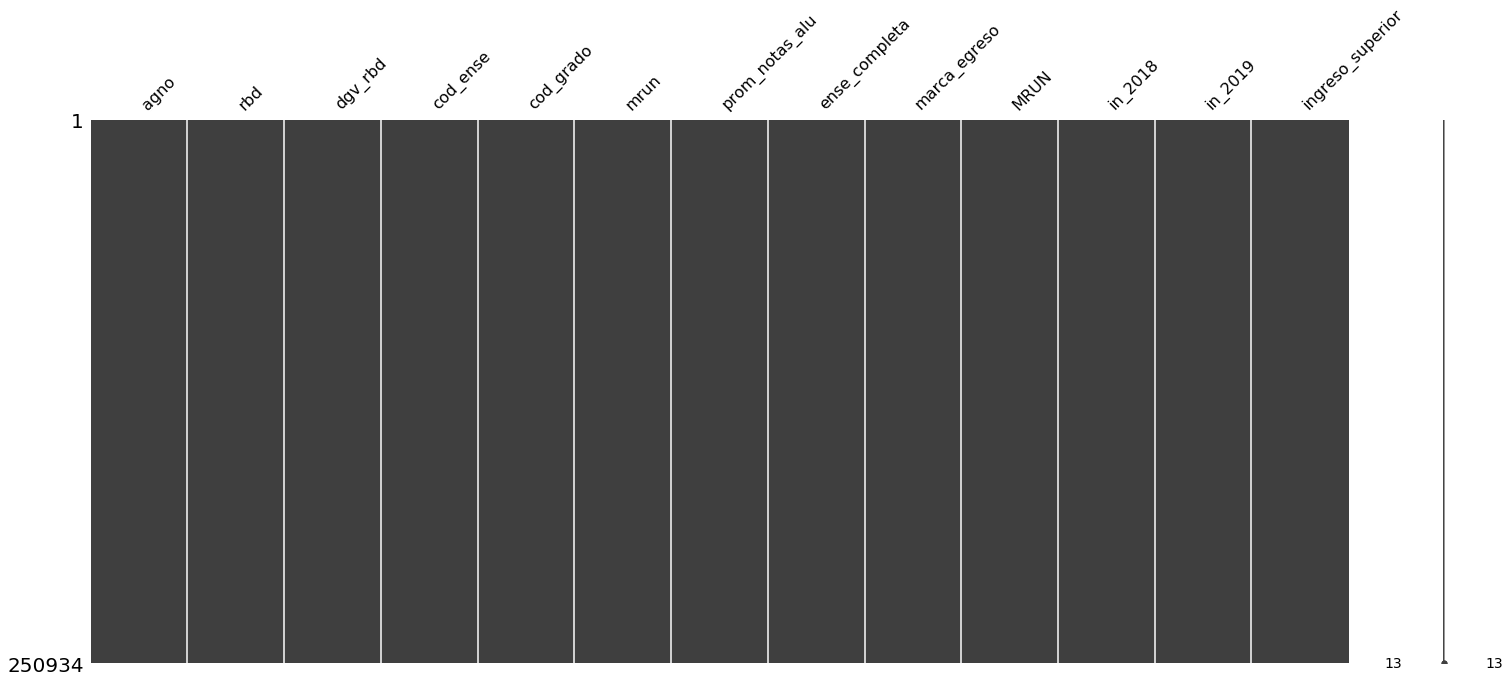

In [74]:
msno.matrix(matricula_general) 

De todos los atributos pandas automáticamente reconocío estos como de tipo no numéricos, de estos solo necesitamos que estrictamente prom_notas_alu (promedio final de cuarto medio) sea numérico.

In [47]:
list(matricula_general.select_dtypes(['object']).columns)

['dgv_rbd', 'prom_notas_alu', 'MRUN']

In [48]:
matricula_general["prom_notas_alu"] = matricula_general["prom_notas_alu"] \
                                      .str.replace(',', '.', regex=True).astype(float)

In [49]:
matricula_general.head(5)

,agno,rbd,dgv_rbd,cod_ense,cod_grado,mrun,prom_notas_alu,ense_completa,marca_egreso,MRUN,in_2018,in_2019,ingreso_superior
0,2017,8505,7,610,4,17,6.4,1,1,17,0,0,0
1,2017,12716,7,610,4,19,6.2,1,1,19,0,0,0
2,2017,25235,2,363,4,51,5.7,1,1,51,0,0,0
3,2017,10892,8,363,4,59,5.4,1,1,59,0,0,0
4,2017,22475,8,363,4,191,5.5,1,1,191,0,0,0


In [50]:
matricula_general.describe()

,agno,rbd,cod_ense,cod_grado,mrun,prom_notas_alu,ense_completa,marca_egreso,in_2018,in_2019,ingreso_superior
count,250934.0,250934.000000,250934.000000,250934.0,2.509340e+05,250934.000000,250934.0,250934.0,250934.000000,250934.000000,250934.000000
mean,2017.0,12255.418604,383.850144,4.0,1.260628e+07,5.673255,1.0,1.0,0.481154,0.186384,0.667538
std,0.0,9216.327352,103.000740,0.0,7.276082e+06,0.682343,0.0,0.0,0.499646,0.389417,0.471096
min,2017.0,0.000000,310.000000,4.0,1.700000e+01,0.000000,1.0,1.0,0.000000,0.000000,0.000000
25%,2017.0,4702.000000,310.000000,4.0,6.316333e+06,5.300000,1.0,1.0,0.000000,0.000000,0.000000
50%,2017.0,9940.000000,363.000000,4.0,1.259515e+07,5.700000,1.0,1.0,0.000000,0.000000,1.000000
75%,2017.0,17858.000000,410.000000,4.0,1.889800e+07,6.100000,1.0,1.0,1.000000,0.000000,1.000000
max,2017.0,99999.000000,910.000000,4.0,2.610349e+07,7.000000,1.0,1.0,1.000000,1.000000,1.000000


Observando a simple vista pordemos deducir rápidamente varios detalles:

1. El atributo agno no es nada útil: valor fijo de 2017.
2. El código de grado es necesariamente 4, que representa precisamente el grado en el cualel individuo puede egresar de media.
3. Ensa_completa es solo un atributo informativo para el analista de datos, pues nos informa si se posee o no cierta información por lo cual podemos prescindir de ella.
4. para el análisis solo es pertinente aquellos que realmente egresan (marca de egreso 1)

Los atributos mencionados que que se manifiesten en un condicional, luego del procesamiento en este punto serán igualmente eliminados.

Por otro lado, se pued visualizar que el rbd (código de instuto de media) y el prome_notas_alu (promedio de notas para cada alumno) tienen valores "0" lo cual carece por completo de sentido. Al revisar el debido diccionario son simplemente datos faltantes y una de la explicación de esto puede ser los estudiantes extranjeros que entran al sistema educativo chileno, debido a que es población posiblemente postulante a la educación superior se consideró pertinente dejarlo; sin embargo, si en el paso de ingeniería de datos compromete el perfomance del algoritmo se reconsiderará su inclusión o se procederá a una recodificación mucho más exacta.

In [51]:
matricula_general = matricula_general[(matricula_general["cod_grado"]==4) & (matricula_general["marca_egreso"]==1)]
matricula_general = matricula_general.drop(["agno","ense_completa","cod_grado","marca_egreso"],axis=1)

A continuación se muestra el porcetanje de ingreso o no ingreso para los datos. Nótese que en el caso de estar procesando el subset, el largo de la muestra tiene la sufiente significancia estadística que no dista mucho de lo que reporta al tomar todos los datos: en general 70% ingreso y 30% no ingreso.

In [52]:
matricula_general["ingreso_superior"].value_counts("%")*100

1    66.753808
0    33.246192
Name: ingreso_superior, dtype: float64

El procedimiento para codificar nuestros datos es el label encoder. Esto es necesario para que el algoritmo pueda tomar datos únicamente numéricos y se eligió el label encoder por encima del dummy codifier, por el simple hecho de que un dummy para datos posteriores (otros checkpoints) con muchas categorías puede aumentar de forma muy sustancial la dimensionalidad de los datos.

In [53]:
len(matricula_general)

250934

In [54]:
def label_encoder(dataframe):
    df = dataframe.copy()
    le = preprocessing.LabelEncoder()
    for element in df.select_dtypes(['object']).columns:
        df[element]= le.fit_transform(df[element].astype(str))
    return df

Se procede a copiar el df original para hacer las pruebas en este checkpoint y se hace "drop" al mrun por ser pertinente en esta predicción (al menos no como lo podríamos emplear en este punto).

In [55]:
matricula_general_1 = matricula_general.copy()
matricula_general_1 = matricula_general_1.drop(["MRUN"],axis=1)

Se temina de pasar "dgv_rbd" (código de dentificación del instituto de egreso) como numérico por requerimiento del algoritmo.

In [56]:
matricula_general_1 = label_encoder(matricula_general_1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(matricula_general_1.drop(["ingreso_superior"],axis=1),
                                                    matricula_general_1["ingreso_superior"], test_size=0.33, 
                                                    random_state=0)

Prueba con random forest

In [58]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     27464
           1       0.91      1.00      0.96     55345

    accuracy                           0.94     82809
   macro avg       0.96      0.91      0.93     82809
weighted avg       0.94      0.94      0.94     82809



Prueba con gradient boost

In [59]:
clf = GradientBoostingClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27464
           1       1.00      1.00      1.00     55345

    accuracy                           1.00     82809
   macro avg       1.00      1.00      1.00     82809
weighted avg       1.00      1.00      1.00     82809



Al tener los primeros resutlados es de CRUCIAL importancia mencionar varios puntos:
    
1. De forma deliberada se rompió dos cosas a lo requerido: mostras más de una métrica y utilizar un algoritmo no reportado; esto está motivado que en este punto del desarrollo, aún no estaba definido ninguna de las dos cosas, por lo cual fue modelo que de forma inicial nos ayudó a guiarnos en la toma de decisiones posterior a este punto (aunque se seguirá haciendo a lo largo de este documento, por de igual forma nos ayudó a tomar decisiones).


2. Obtener unas métricas (todas: recall, precision, f1, accuracy y me atrevería a decir que incluso auc pese a no ser calculado) en su mayoría por encima de los 0.7, lo que indica que la resolución de esta problemática es sumamente viable. 

## Segundo checkpoint (merge con matrícula de media)

Importación de los datos de matricula de media

In [60]:
matricula_media = pd.read_csv(r"C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1/20170921_Matricula_unica_2017_20170430_PUBL.csv",sep=";", decimal=".")

Mismo procedimiento para normalizar el key para hacer el merge.

In [61]:
matricula_media["MRUN"] = matricula_media["mrun"]
matricula_media.drop(["mrun"],axis=1)
matricula_media = matricula_media.drop_duplicates(subset=["MRUN"],keep="first")

Se nota una cantidad de atributos mayor con respecto a nuestro base.

In [90]:
list(matricula_media.columns)

['agno',
 'rbd',
 'dgv_rbd',
 'nom_rbd',
 'cod_reg_rbd',
 'cod_pro_rbd',
 'cod_com_rbd',
 'nom_com_rbd',
 'cod_deprov_rbd',
 'nom_deprov_rbd',
 'cod_depe',
 'cod_depe2',
 'rural_rbd',
 'estado_estab',
 'cod_ense',
 'cod_ense2',
 'cod_ense3',
 'cod_grado',
 'cod_grado2',
 'let_cur',
 'cod_jor',
 'cod_tip_cur',
 'cod_des_cur',
 'mrun',
 'gen_alu',
 'fec_nac_alu',
 'edad_alu',
 'cod_reg_alu',
 'cod_com_alu',
 'nom_com_alu',
 'cod_sec',
 'cod_espe',
 'cod_rama',
 'cod_men',
 'ens',
 'MRUN']

Esta línea de código fue ejecutada para saber qué columnas se encuentran en matricula_general que no encuentren en matricula_media, esto con el fin de evitar los molestos col_x y col_y que se generan al mergear. Luego se genera el respectivo merge. Se realiza un inner, con el fin de obtener la información de solo los egresados de 4to media, pues el dataset de matricula media incluye todos los datos de todos los grados.

In [62]:
cols_to_use = list(matricula_general.columns.difference(matricula_media.columns))
cols_to_use.append("MRUN")
matricula_general = pd.merge(matricula_general[cols_to_use], matricula_media,
                                   how='inner',on=["MRUN"])

In [92]:
matricula_general

,in_2018,in_2019,ingreso_superior,prom_notas_alu,MRUN,agno,rbd,dgv_rbd,nom_rbd,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,nom_com_rbd,cod_deprov_rbd,nom_deprov_rbd,cod_depe,cod_depe2,rural_rbd,estado_estab,cod_ense,cod_ense2,cod_ense3,cod_grado,cod_grado2,let_cur,cod_jor,cod_tip_cur,cod_des_cur,mrun,gen_alu,fec_nac_alu,edad_alu,cod_reg_alu,cod_com_alu,nom_com_alu,cod_sec,cod_espe,cod_rama,cod_men,ens
0,0,0,0,6.4,17,2017,8505,7,LICEO POLIVALENTE A-28 EMILIA TORO DE BAL,13,131,13101,SANTIAGO,131,SANTIAGO CENTRO,5,4,0,1,610,7,6,4,4,A,1,0,1,17,2,199810,18,13,13103,CERRO NAVIA,610,61002,600,0,8
1,0,0,0,6.2,19,2017,12716,7,COLEGIO MIRAMAR,15,151,15101,ARICA,151,ARICA,3,2,0,1,610,7,6,4,4,B,3,0,1,19,2,199909,17,15,15101,ARICA,620,62006,600,,8
2,0,0,0,6.1,346,2017,3909,8,LICEO POLIVALENTE JUVENAL HERNÁNDEZ JAQUE,8,84,8407,EL CARMEN,81,ÑUBLE,2,1,0,1,310,5,4,4,4,D,3,0,0,346,2,200005,17,8,8407,EL CARMEN,0,0,0,,7
3,0,0,0,5.8,385,2017,6830,6,COLEGIO NUESTRA SENORA DEL CARMEN,14,141,14101,VALDIVIA,141,VALDIVIA,3,2,0,1,310,5,4,4,4,A,1,0,0,385,2,200006,17,14,14101,VALDIVIA,0,0,0,0,7
4,0,0,0,5.8,386,2017,16843,2,LICEO TECNICO PROFESIONAL PEOPLE HELP PEOPLE D...,14,141,14108,PANGUIPULLI,141,VALDIVIA,3,2,0,1,510,7,6,4,4,E,3,0,1,386,1,200005,17,14,14108,PANGUIPULLI,530,53014,500,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233358,0,0,0,5.7,25557799,2017,8919,2,COLEGIO SAN PEDRO NOLASCO,13,131,13132,VITACURA,133,SANTIAGO ORIENTE,4,3,0,1,310,5,4,4,4,B,3,0,0,25557799,1,199906,18,13,13132,VITACURA,0,0,0,0,7
233359,0,0,0,5.6,25557819,2017,24754,5,CEIA GEORGINA SALAS DINAMARCA,13,131,13103,CERRO NAVIA,134,SANTIAGO PONIENTE,1,1,0,1,363,6,5,3,4,D,4,0,0,25557819,1,198001,37,13,13103,CERRO NAVIA,0,0,0,,12
233360,0,1,1,6.1,25557842,2017,25722,2,COLEGIO PART. PATRONA SENORA DE LOURDES,13,131,13110,LA FLORIDA,136,CORDILLERA,3,2,0,1,310,5,4,4,4,A,3,0,0,25557842,2,200004,17,13,13110,LA FLORIDA,0,0,0,,7
233361,1,0,1,5.6,25557874,2017,5810,6,COLEGIO BAUTISTA,9,91,9101,TEMUCO,92,CAUTIN NORTE,4,3,0,1,310,5,4,4,4,B,3,0,0,25557874,1,199905,18,9,9101,TEMUCO,0,0,0,0,7


In [63]:
matricula_general.drop(columns=['agno', 'dgv_rbd', 'nom_rbd', 'cod_deprov_rbd', 'cod_depe', 'estado_estab',
                               'cod_ense2', 'cod_ense3', 'cod_grado', 'let_cur', 'cod_tip_cur', 'mrun', 'fec_nac_alu',  
                                'cod_sec', 'cod_espe', 'cod_rama', 'cod_men', 'ens'], inplace=True)

In [64]:
matricula_general.rename({'rbd':'RBD'}, axis='columns', inplace=True)
matricula_general

,in_2018,in_2019,ingreso_superior,prom_notas_alu,MRUN,RBD,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,nom_com_rbd,nom_deprov_rbd,cod_depe2,rural_rbd,cod_ense,cod_grado2,cod_jor,cod_des_cur,gen_alu,edad_alu,cod_reg_alu,cod_com_alu,nom_com_alu
0,0,0,0,6.4,17,8505,13,131,13101,SANTIAGO,SANTIAGO CENTRO,4,0,610,4,1,1,2,18,13,13103,CERRO NAVIA
1,0,0,0,6.2,19,12716,15,151,15101,ARICA,ARICA,2,0,610,4,3,1,2,17,15,15101,ARICA
2,0,0,0,6.1,346,3909,8,84,8407,EL CARMEN,ÑUBLE,1,0,310,4,3,0,2,17,8,8407,EL CARMEN
3,0,0,0,5.8,385,6830,14,141,14101,VALDIVIA,VALDIVIA,2,0,310,4,1,0,2,17,14,14101,VALDIVIA
4,0,0,0,5.8,386,16843,14,141,14108,PANGUIPULLI,VALDIVIA,2,0,510,4,3,1,1,17,14,14108,PANGUIPULLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233358,0,0,0,5.7,25557799,8919,13,131,13132,VITACURA,SANTIAGO ORIENTE,3,0,310,4,3,0,1,18,13,13132,VITACURA
233359,0,0,0,5.6,25557819,24754,13,131,13103,CERRO NAVIA,SANTIAGO PONIENTE,1,0,363,4,4,0,1,37,13,13103,CERRO NAVIA
233360,0,1,1,6.1,25557842,25722,13,131,13110,LA FLORIDA,CORDILLERA,2,0,310,4,3,0,2,17,13,13110,LA FLORIDA
233361,1,0,1,5.6,25557874,5810,9,91,9101,TEMUCO,CAUTIN NORTE,3,0,310,4,3,0,1,18,9,9101,TEMUCO


En la siguiente gráfica se mostrará un data set sin datos nuelos, al menos no de forma aparente. La información de las categorías codificadas se encuentra en el respectivo diccionario del dataset, y por los momentos se ha tomado la decisión de incluirlas con el motivo de verificar su influencia en el entrenamiento de los modelos.

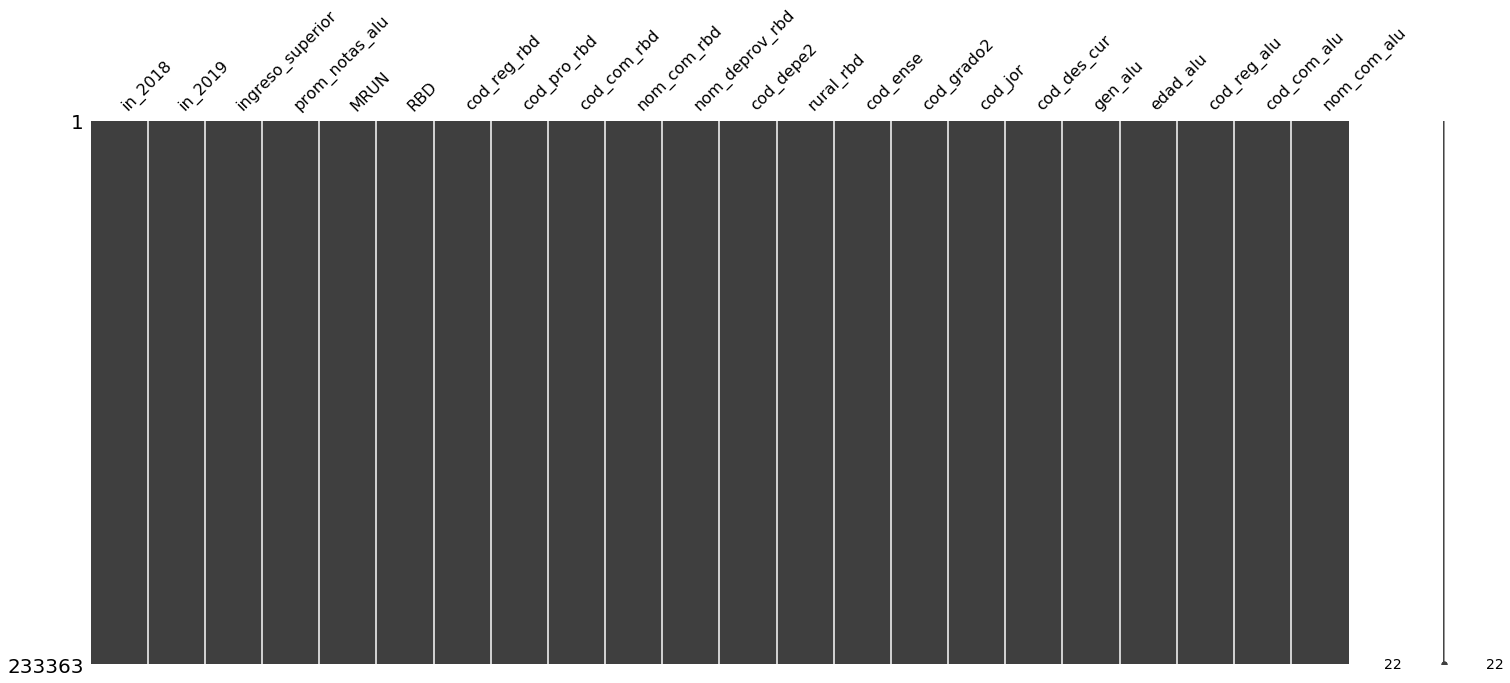

In [95]:
msno.matrix(matricula_general) 

## Tercer checkpoint se agrega información de puntaje PSU promedio y NEM promedio por establecimiento

- Se obtiene desde DataChile el set de datos correspondiente a los puntajes promedio PSU y NEM de diferentes establacimientos vigente durante año 2017, es decir prueba PSU rendida en año 2016, en concordancia con el objetivo de este proyecto y modelo a generar.

- Procesamiento corto: se cambio el nombre del id del instuto al normalizado.

In [65]:
psu_nem_establecimiento = pd.read_csv(r'C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1\PSU_NEM por establecimiento.csv',
                                        error_bad_lines=False, sep=',')
psu_nem_establecimiento_select = psu_nem_establecimiento.loc[:, ['ID Institution', 'Average PSU', 'Average NEM']]
psu_nem_establecimiento_select.rename({'ID Institution':'RBD'}, axis='columns', inplace=True)
psu_nem_establecimiento_select.head(5)

matricula_general = psu_nem_establecimiento_select.merge(matricula_general, left_on='RBD', right_on='RBD')
matricula_general

,RBD,Average PSU,Average NEM,in_2018,in_2019,ingreso_superior,prom_notas_alu,MRUN,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,nom_com_rbd,nom_deprov_rbd,cod_depe2,rural_rbd,cod_ense,cod_grado2,cod_jor,cod_des_cur,gen_alu,edad_alu,cod_reg_alu,cod_com_alu,nom_com_alu
0,1,415.960227,5.585470,0,0,0,6.0,20754,15,151,15101,ARICA,ARICA,1,0,563,4,4,1,1,35,1,1101,IQUIQUE
1,1,415.960227,5.585470,0,0,0,5.7,223163,15,151,15101,ARICA,ARICA,1,0,563,4,4,1,1,29,15,15101,ARICA
2,1,415.960227,5.585470,0,0,0,5.4,618536,15,151,15101,ARICA,ARICA,1,0,663,4,4,1,2,21,2,2101,ANTOFAGASTA
3,1,415.960227,5.585470,0,0,0,6.7,639205,15,151,15101,ARICA,ARICA,1,0,610,4,1,1,2,17,15,15101,ARICA
4,1,415.960227,5.585470,0,0,0,6.2,689523,15,151,15101,ARICA,ARICA,1,0,610,4,1,1,2,17,15,15101,ARICA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233276,10541,453.980315,5.394201,1,0,1,6.3,24046519,13,134,13401,SAN BERNARDO,SANTIAGO SUR,4,0,410,4,1,1,1,17,13,13116,LO ESPEJO
233277,10541,453.980315,5.394201,1,0,1,5.6,24069189,13,134,13401,SAN BERNARDO,SANTIAGO SUR,4,0,410,4,3,3,1,17,13,13401,SAN BERNARDO
233278,10541,453.980315,5.394201,1,0,1,6.1,24384950,13,134,13401,SAN BERNARDO,SANTIAGO SUR,4,0,410,4,1,3,2,18,13,13401,SAN BERNARDO
233279,10541,453.980315,5.394201,0,1,1,5.9,24431844,13,134,13401,SAN BERNARDO,SANTIAGO SUR,4,0,410,4,1,3,2,17,13,13401,SAN BERNARDO


#### Comentarios: Existen solo 82 registros de los cuales no se posee información del colegio en el set de datos de PSU, se toma la desición de ignorarlos al ser pocos dentro de la muestra em ves de mantenerlos sin información.

## Vulnerabilidad establecimiento

- Se utiliza el set de datos correspondiente a la matricula por establecimiento el año 2017 e información de estudiantes preferentes y prioritarios por establecimiento.

- En base a esta información se calcula un indice de vulnerabilidad atribuible al establecimiento de la siguiente manera:

    I_VUL: (cantidad_alumnos_preferentes + cantidad_alumnos_prioritarios) / cantidad_de_alumnos


- Es importante mencionar que los que una de las condiciones excluyentes para tener la clasificación como alumno preferente o prioritario es pertenecer a un colegio municipal o subvencionado.


- El artículo 2º de la Ley 20.248, establece que se considera como “Prioritarios”, a los alumnos para quienes la situación socioeconómica de sus hogares dificulte sus posibilidades de enfrentar el proceso educativo.


- Se considera como “Preferente” a los alumnos que no tienen la calidad de alumno prioritario y cuyas familias pertenecen al 80% más vulnerable de la población; según el instrumento de caracterización social vigente (Registro Social de Hogares). Se incorporan a la base de datos a partir del año 2016.

In [66]:
matricula_establecimiento = pd.read_csv(r'C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1\Resumen_Matricula_EE_2017_Oficial.csv',
                                 error_bad_lines=False, sep=';', decimal=',')
matricula_establecimiento = matricula_establecimiento.loc[:, ['RBD', 'MAT_TOTAL']]
matricula_establecimiento.head(3)

,RBD,MAT_TOTAL
0,1,802
1,2,200
2,3,504


In [69]:
alum_prioritarios_establecimiento = pd.read_csv(r'C:\Users\matim\Documents\Matias\Curso Desafio_Latam\Proyecto final\Entrega hito_1\Preferentes_Prioritarios_y_Beneficiarios_2017_20171030_PUBL.csv',
                                 error_bad_lines=False, sep=';', decimal=',')


In [71]:
alum_prioritarios_establecimiento.head()

,AGNO,MRUN,GEN_ALU,FEC_NAC_ALU,CRITERIO_SEP,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,NOM_DEPROV_RBD,COD_DEPE,COD_DEPE2,RURAL_RBD,ESTADO_ESTAB,CONVENIO_SEP,AÑO_INGRESO_SEP,CLASIFICACION_SEP,EE_GRATUITO,COD_ENSE,COD_ENSE2,COD_ENSE3,COD_GRADO,COD_GRADO2,LET_CUR,COD_JOR,GRADO_SEP,PRIORITARIO_ALU,PREFERENTE_ALU,BEN_SEP
0,2017,17,2,199810,1,8505,7,LICEO POLIVALENTE A-28 EMILIA TORO DE BAL,13,131,13101,SANTIAGO,131,SANTIAGO CENTRO,5,4,0,1,0,,,0,610,7,6,4,4,A,1,1,1,0,0
1,2017,19,2,199909,2,12716,7,COLEGIO MIRAMAR,15,151,15101,ARICA,151,ARICA,3,2,0,1,1,2008,AUTONOMO,1,610,7,6,4,4,B,3,1,1,0,1
2,2017,20,2,199909,1,12712,4,COLEGIO CHILE NORTE,15,151,15101,ARICA,151,ARICA,3,2,0,1,1,2008,EMERGENTE,1,310,5,4,2,2,B,3,1,1,0,1
3,2017,25,1,200212,0,1579,2,LICEO SANTA TERESA,5,51,5101,VALPARAISO,53,VALPARAISO,3,2,0,1,1,2016,EMERGENTE,1,310,5,4,1,1,A,1,1,0,1,1
4,2017,31,1,201312,1,26281,1,ESCUELA ESPECIAL EL TREBOL,13,136,13604,PADRE HURTADO,135,TALAGANTE,3,2,0,1,0,,,1,214,4,1,2,3,C,2,0,1,0,0


In [70]:
alum_prioritarios_establecimiento = alum_prioritarios_establecimiento.loc[:, ['RBD', 'N_PRIO', 'N_PREF']]
alum_prioritarios_establecimiento['N_AVUL'] = alum_prioritarios_establecimiento['N_PRIO'] + alum_prioritarios_establecimiento['N_PREF'] # cantidad Alumnos vulnerables = N_AVUL
alum_prioritarios_establecimiento.head(3)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

- N_PRIO: Cantidad alumnos prioritarios 
- N_PREF: Cantidad alumnos preferentes
- N_AVUL: Cantidad alumnos vulnerables

In [ ]:
matricula_establecimiento_alumnos_vulnerables = matricula_establecimiento.merge(alum_prioritarios_establecimiento, left_on='RBD', right_on='RBD')
matricula_establecimiento_alumnos_vulnerables['I_VUL'] =  matricula_establecimiento_alumnos_vulnerables['N_AVUL'] / matricula_establecimiento_alumnos_vulnerables['MAT_TOTAL'] # indice de vulnerabilidad = I_VUL
matricula_establecimiento_alumnos_vulnerables.head(3)

In [100]:
matricula_establecimiento_alumnos_vulnerables.drop(columns = ['MAT_TOTAL', 'N_PRIO', 'N_PREF', 'N_AVUL'], inplace=True)
matricula_establecimiento_alumnos_vulnerables.head(3)

,RBD,I_VUL
0,1,0.815461
1,2,0.530000
2,3,0.182540


In [101]:
matricula_general = pd.merge(matricula_general, matricula_establecimiento_alumnos_vulnerables, on='RBD', how='outer')
matricula_general = matricula_general[matricula_general['MRUN'].isin(list(egreso.mrun.values))]
matricula_general

,RBD,Average PSU,Average NEM,in_2018,in_2019,ingreso_superior,prom_notas_alu,MRUN,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,nom_com_rbd,nom_deprov_rbd,cod_depe2,rural_rbd,cod_ense,cod_grado2,cod_jor,cod_des_cur,gen_alu,edad_alu,cod_reg_alu,cod_com_alu,nom_com_alu,I_VUL
0,1,415.960227,5.585470,0.0,0.0,0.0,6.0,20754,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,563.0,4.0,4.0,1.0,1.0,35,1.0,1101.0,IQUIQUE,0.815461
1,1,415.960227,5.585470,0.0,0.0,0.0,5.7,223163,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,563.0,4.0,4.0,1.0,1.0,29,15.0,15101.0,ARICA,0.815461
2,1,415.960227,5.585470,0.0,0.0,0.0,5.4,618536,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,663.0,4.0,4.0,1.0,2.0,21,2.0,2101.0,ANTOFAGASTA,0.815461
3,1,415.960227,5.585470,0.0,0.0,0.0,6.7,639205,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,610.0,4.0,1.0,1.0,2.0,17,15.0,15101.0,ARICA,0.815461
4,1,415.960227,5.585470,0.0,0.0,0.0,6.2,689523,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,610.0,4.0,1.0,1.0,2.0,17,15.0,15101.0,ARICA,0.815461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233276,10541,453.980315,5.394201,1.0,0.0,1.0,6.3,24046519,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,1.0,1.0,17,13.0,13116.0,LO ESPEJO,0.905721
233277,10541,453.980315,5.394201,1.0,0.0,1.0,5.6,24069189,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,3.0,3.0,1.0,17,13.0,13401.0,SAN BERNARDO,0.905721
233278,10541,453.980315,5.394201,1.0,0.0,1.0,6.1,24384950,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,3.0,2.0,18,13.0,13401.0,SAN BERNARDO,0.905721
233279,10541,453.980315,5.394201,0.0,1.0,1.0,5.9,24431844,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,3.0,2.0,17,13.0,13401.0,SAN BERNARDO,0.905721


#### Debido a que solo los colegios minucipales y subvencionados poseen alumnos prioritarios y preferentes, adicionalmente a que solo estos colegios se encuentran en el dataset, los colegios que no se encuentran en el registro se les asigna un indice de vulnerabilidad de 0 ya que no tienen en matriculas estudiantes con esta condición.

In [102]:
matricula_general['I_VUL'].fillna(0, inplace=True)

In [111]:
matricula_general.to_csv(r'C:\Users\cgaetes\Desktop\data proyecto\dataset hito 1\dataset_final.csv', index=None)

In [112]:
matricula_general

,RBD,Average PSU,Average NEM,in_2018,in_2019,ingreso_superior,prom_notas_alu,MRUN,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,nom_com_rbd,nom_deprov_rbd,cod_depe2,rural_rbd,cod_ense,cod_grado2,cod_jor,cod_des_cur,gen_alu,edad_alu,cod_reg_alu,cod_com_alu,nom_com_alu,I_VUL
0,1,415.960227,5.585470,0.0,0.0,0.0,6.0,20754,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,563.0,4.0,4.0,1.0,1.0,35,1.0,1101.0,IQUIQUE,0.815461
1,1,415.960227,5.585470,0.0,0.0,0.0,5.7,223163,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,563.0,4.0,4.0,1.0,1.0,29,15.0,15101.0,ARICA,0.815461
2,1,415.960227,5.585470,0.0,0.0,0.0,5.4,618536,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,663.0,4.0,4.0,1.0,2.0,21,2.0,2101.0,ANTOFAGASTA,0.815461
3,1,415.960227,5.585470,0.0,0.0,0.0,6.7,639205,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,610.0,4.0,1.0,1.0,2.0,17,15.0,15101.0,ARICA,0.815461
4,1,415.960227,5.585470,0.0,0.0,0.0,6.2,689523,15.0,151.0,15101.0,ARICA,ARICA,1.0,0.0,610.0,4.0,1.0,1.0,2.0,17,15.0,15101.0,ARICA,0.815461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233276,10541,453.980315,5.394201,1.0,0.0,1.0,6.3,24046519,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,1.0,1.0,17,13.0,13116.0,LO ESPEJO,0.905721
233277,10541,453.980315,5.394201,1.0,0.0,1.0,5.6,24069189,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,3.0,3.0,1.0,17,13.0,13401.0,SAN BERNARDO,0.905721
233278,10541,453.980315,5.394201,1.0,0.0,1.0,6.1,24384950,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,3.0,2.0,18,13.0,13401.0,SAN BERNARDO,0.905721
233279,10541,453.980315,5.394201,0.0,1.0,1.0,5.9,24431844,13.0,134.0,13401.0,SAN BERNARDO,SANTIAGO SUR,4.0,0.0,410.0,4.0,1.0,3.0,2.0,17,13.0,13401.0,SAN BERNARDO,0.905721


## Modelos preliminares exploratorios
- Correspponde a modelos solamente exploratorios, no posee tratamiento de datos, ej: no se encuentran binarizadas las variables categoricas

Copia necesaria para mantener nuestro df original sin codificación, al menos por los momentos.

In [115]:
matricula_general_2 = matricula_general.copy()
matricula_general_2 = matricula_general_2.dropna()
matricula_general_2 = matricula_general_2.drop(columns= ['in_2018', 'in_2019']) # si se mantiendes tendrían correlación tendiente a 1 con el vestor objetivo

In [107]:
matricula_general_2 = label_encoder(matricula_general_2)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(matricula_general_2.drop(["ingreso_superior"],axis=1),
                                                    matricula_general_2["ingreso_superior"], test_size=0.33,
                                                    random_state=0)

In [109]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.17      0.27     22881
         1.0       0.73      0.97      0.83     52772

    accuracy                           0.72     75653
   macro avg       0.70      0.57      0.55     75653
weighted avg       0.71      0.72      0.66     75653



In [113]:
clf = GradientBoostingClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55     22881
         1.0       0.80      0.89      0.84     52772

    accuracy                           0.77     75653
   macro avg       0.73      0.68      0.70     75653
weighted avg       0.75      0.77      0.75     75653



Aquí se pueden notar varios puntos:
 
1. En promedio el rendimiento de random forest es pobre y esto puede ser explicado debido que el algoritmo se está quedando muy corto con respecto a la nueva complejidad de la data, esto se podría solventar con un buen "tuning" o con un algoritmo más robusto (pero buscar un buen perfomance mediante diversas técnicas NO es el objetivo de este analisis)
2. En los dos algoritmos se puede notar que en general se aumentó el mucho el rendimiento de la clase mayoritaria en detrimento de la minoritaría.

Para tratar de reducir estos efectos mencionados, en la ingenería de datos se ve en la tarea de "pulir" los datos.

# Análsis exploratorio

- Gran parte del analisis exploratorio se realiza en power BI, por lo que en este archivo es parcial

In [131]:
matricula_general.describe()

,RBD,Average PSU,Average NEM,in_2018,in_2019,ingreso_superior,prom_notas_alu,cod_reg_rbd,cod_pro_rbd,cod_com_rbd,cod_depe2,rural_rbd,cod_ense,cod_grado2,cod_jor,cod_des_cur,gen_alu,cod_reg_alu,cod_com_alu,I_VUL
count,233281.000000,229324.000000,229332.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.00000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000,233281.000000
mean,12273.326748,485.299285,5.579525,0.502724,0.192849,0.695573,5.725363,9.26886,94.657790,9472.363026,1.813431,0.030735,386.016002,4.006571,2.674676,0.376726,1.514530,9.274407,9478.798085,0.714141
std,9151.559178,69.709559,0.232267,0.499994,0.394536,0.460165,0.570865,3.81856,37.922663,3795.451440,0.754817,0.172600,107.077066,1.080137,0.922955,0.606588,0.499798,3.840099,3819.681652,0.263594
min,1.000000,262.000000,4.798182,0.000000,0.000000,0.000000,0.000000,1.00000,11.000000,1101.000000,1.000000,0.000000,167.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4805.000000,431.792899,5.415213,0.000000,0.000000,0.000000,5.300000,6.00000,61.000000,6108.000000,1.000000,0.000000,310.000000,4.000000,3.000000,0.000000,1.000000,6.000000,6110.000000,0.629100
50%,9917.000000,468.723558,5.558542,1.000000,0.000000,1.000000,5.700000,9.00000,91.000000,9120.000000,2.000000,0.000000,310.000000,4.000000,3.000000,0.000000,2.000000,9.000000,9201.000000,0.802500
75%,17857.000000,531.151163,5.713193,1.000000,0.000000,1.000000,6.200000,13.00000,131.000000,13119.000000,2.000000,0.000000,410.000000,4.000000,3.000000,1.000000,2.000000,13.000000,13119.000000,0.903409
max,40457.000000,691.133858,6.630000,1.000000,1.000000,1.000000,7.000000,15.00000,152.000000,15201.000000,4.000000,1.000000,910.000000,99.000000,4.000000,3.000000,2.000000,15.000000,15202.000000,1.000000


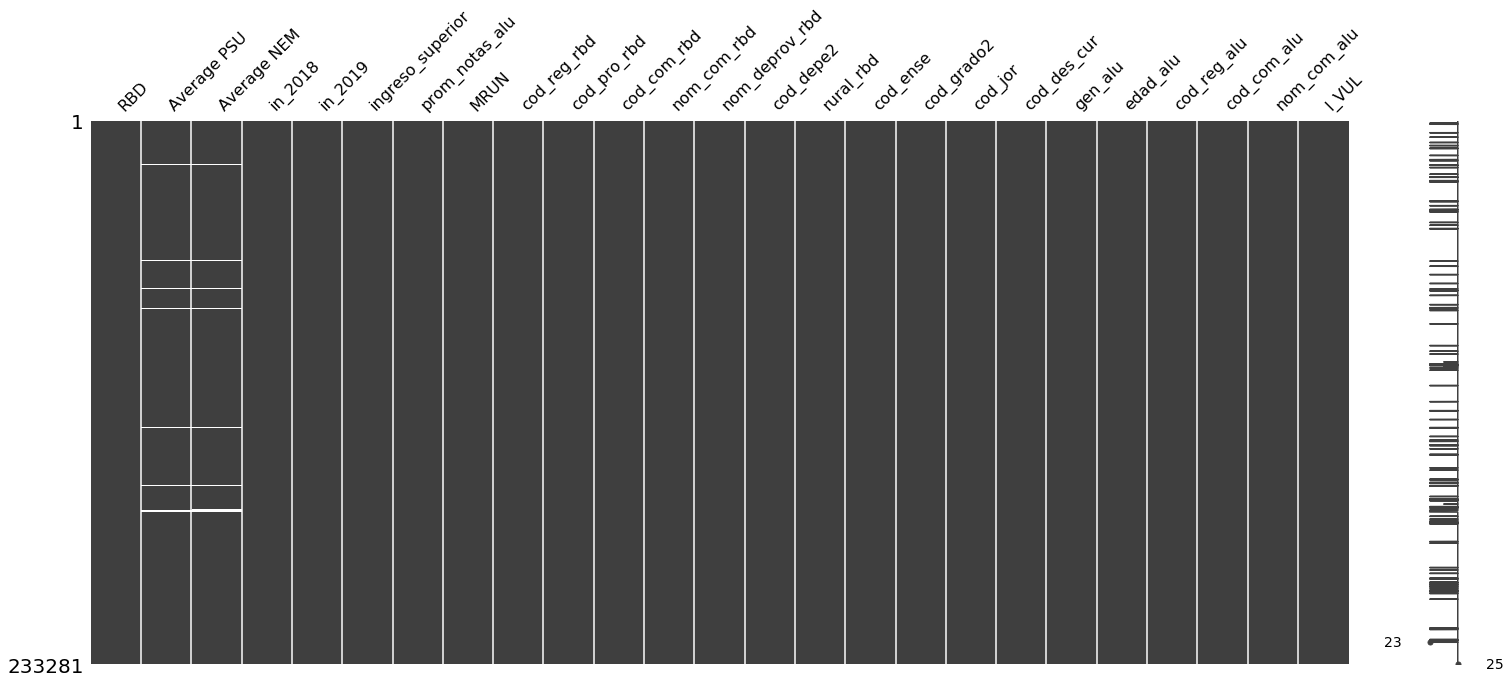

In [122]:
msno.matrix(matricula_general) 

In [150]:
index_null_psu = matricula_general[matricula_general['Average PSU'].isnull()].index
index_null_NEM = matricula_general[matricula_general['Average NEM'].isnull()].index
cantidad_resgistros_null = len(np.unique(np.concatenate((index_null_NEM, index_null_psu))))
print('Cantidad de registros con datos perdidos = ', cantidad_resgistros_null, 
      f'({round(cantidad_resgistros_null*100/len(matricula_general), 2)}%)')

Cantidad de registros con datos perdidos =  4032 (1.73%)


### Comentarios:
- Se observan datos perdidos solo en dos columnas (Average PSU y Average NEM)
- LA totalidad de resgistros con datos perdidos correspnden a 4032 equivalentes al 1.73% de los datos

### - Distribución de notas de estudiantes egresados de enseñanza media segun ingreso a la educación superior

Text(0.5, 1.0, 'Distribución de notas de egresados')

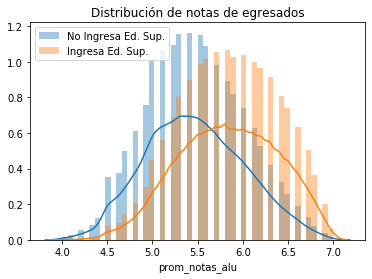

In [119]:
data_notas = matricula_general.loc[:, ['prom_notas_alu', 'ingreso_superior']]
sns.distplot(data_notas[(data_notas['prom_notas_alu']>0) & 
                                        (data_notas['ingreso_superior']==0)]['prom_notas_alu'], label='No Ingresa Ed. Sup.')

sns.distplot(data_notas[(data_notas['prom_notas_alu']>0) & 
                                        (data_notas['ingreso_superior']==1)]['prom_notas_alu'], label='Ingresa Ed. Sup.')

plt.legend()
plt.title('Distribución de notas de egresados')

#### Comentarios:
- Se observa que las notas de 4to medio de los estudiantes que ingresan a la educación superior tienden a ser superiores a las notas de los estudiantes que no ingresan.

- Se observan distribuciones tendientes a normal pero no son perfectamente simétricas.

In [204]:
notas_ingresa = data_notas[(data_notas['prom_notas_alu']>0) & (data_notas['ingreso_superior']==1)]['prom_notas_alu']
notas_no_ingresa = data_notas[(data_notas['prom_notas_alu']>0) & (data_notas['ingreso_superior']==0)]['prom_notas_alu']

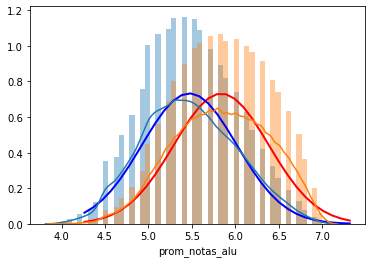

In [205]:
plt.plot(bins, 1/(notas_ingresa.std() * np.sqrt(2 * np.pi)) * np.exp( - (bins - notas_ingresa.mean())**2 / 
                                                                     (2 * notas_ingresa.std()**2) ), linewidth=2, color='r')

plt.plot(bins, 1/(notas_no_ingresa.std() * np.sqrt(2 * np.pi)) * np.exp( - (bins - notas_no_ingresa.mean())**2 / 
                                                                     (2 * notas_no_ingresa.std()**2) ), linewidth=2, color='b')

data_notas = matricula_general.loc[:, ['prom_notas_alu', 'ingreso_superior']]
sns.distplot(data_notas[(data_notas['prom_notas_alu']>0) & 
                                        (data_notas['ingreso_superior']==0)]['prom_notas_alu'], label='No Ingresa Ed. Sup.', 
             hist=True)

sns.distplot(data_notas[(data_notas['prom_notas_alu']>0) & 
                                        (data_notas['ingreso_superior']==1)]['prom_notas_alu'], label='Ingresa Ed. Sup.', 
             hist=True)

In [230]:
kstest(notas_ingresa.values, 'norm')

KstestResult(statistic=0.9999683287581669, pvalue=0.0)

In [231]:
kstest(notas_no_ingresa.values, 'norm')

KstestResult(statistic=0.9999683287581669, pvalue=0.0)

#### Comentarios:

- Al contrastar ambas distribuciones con curvas perfectamente normales se observa que la distribución de las notas de los estudiantes que no ingresan a la educación superior tiene una mayor tendencia a normalidad que la distribución de los que ingresan. En ambos casos se observan valores de frecuencia relativa por fuera de la curva de distribución normal.

- Para evaluar si las distribuciones se pueden considerar normales se realiza la prueba de Kolmogorov-Smirnov considerando la cantidad de datos de los cuales se dispone. Al observa los pvalue obtenidos y considerando una significancia de 0.05, se rechaza la hipótesis nula de que la distribución es idéntica a una distribución normal.

### - Distribución indice de vulnerabilidad 

Distribución del indice de vulnerabilidad


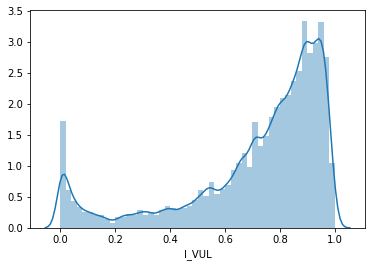

In [256]:
sns.distplot(matricula_general['I_VUL'], label='Ingresa Ed. Sup.', hist=True)
print('Distribución del indice de vulnerabilidad')

#### Comentarios:
- Se observa una distribución bimodal en donde la mayoría de los estudiantes del daset tienden a pertener a establecimientos con altos indices de vulnerabilidad.

- También se observa una segunda concentración de estudiantes pero inferior a la comentada en el punto anterior, en valores bajos de indice de vulnerabilidad, tendientes a cero.

indice de vulnerabilidad promedio por provincia


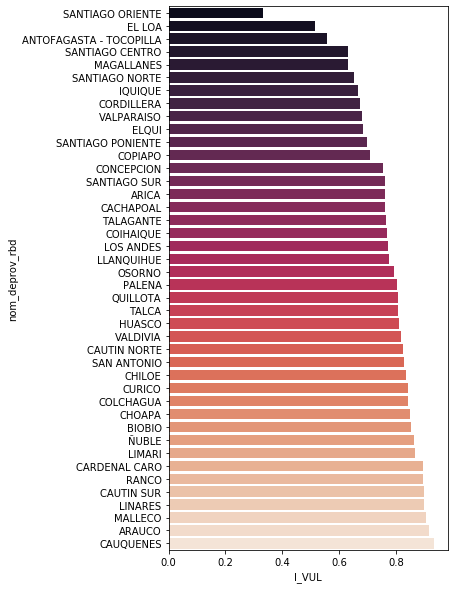

In [255]:
plt.figure(figsize=(5,10))
groupby_I_VUL = matricula_general.groupby(by='nom_deprov_rbd').mean().sort_values(by='I_VUL')['I_VUL']
sns.barplot(x=groupby_I_VUL, y=groupby_I_VUL.index, palette="rocket")
print('indice de vulnerabilidad promedio por provincia')

#### Comentarios:
- Al observar los puntajes promedio de idice de vulnerabilidad por provincia, se puede observar claramente que los establecimientos del sector oriente de santiago son los que presentan menor cantidad de estudiantes vulnerables (prioritarios y preferentes) en promedio. Y se observa un valor promedio escapado del resto de provincias.

- En más de la mitad de las regiones se observan indices por sobre el 60%.

- Los mayores indices se registran entre Cardenal Caro y Cauquenes (en el orden del grafico) en donde en promedio los estudiantes vulnerables por establecimiento superan el 80%, y muy cercano al 90% en el caso de Cauquenes.